<a href="https://colab.research.google.com/github/Iman6243/AI/blob/main/MobilSENSOR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Clear All Variables

In [27]:
%reset -f
#del my_variable

ERROR:root:Unexpected exception finding object shape
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/google/colab/_debugpy_repr.py", line 54, in get_shape
    shape = getattr(obj, 'shape', None)
  File "/usr/local/lib/python3.10/dist-packages/werkzeug/local.py", line 318, in __get__
    obj = instance._get_current_object()
  File "/usr/local/lib/python3.10/dist-packages/werkzeug/local.py", line 519, in _get_current_object
    raise RuntimeError(unbound_message) from None
RuntimeError: Working outside of request context.

This typically means that you attempted to use functionality that needed
an active HTTP request. Consult the documentation on testing for
information about how to avoid this problem.


## PIP instaiitions

In [ ]:
!pip install  sktime-dl
!pip install sktime[all_extras]
!pip install dash
 # https://stumpy.readthedocs.io/en/latest/
!pip install stumpy
# https://towardsdatascience.com/a-brief-introduction-to-time-series-classification-algorithms-7b4284d31b97
# https://github.com/sktime/sktime
!pip install sktime

## Packges

In [29]:
#import dash
import json
import folium
import socket
#import stumpy
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as pl
from statistics import mean
from scipy.stats import norm
import matplotlib.pyplot as plt
from collections import deque
from datetime import datetime
#from dash import dcc, html, dcc
from flask import Flask, request
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
import plotly.graph_objects as go
from scipy.signal import find_peaks
from scipy.signal import savgol_filter
from scipy.ndimage import gaussian_filter1d
from sklearn.metrics import roc_curve, auc
#from dash.dependencies import Output, Input
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.cluster import AgglomerativeClustering
from sklearn.model_selection import train_test_split
from scipy.cluster.hierarchy import dendrogram, linkage

## Color and Style Plot

In [10]:
# Access the named colors
named_colors = pl.colors.CSS4_COLORS
# ایجاد آرایه برای ستون اول
column1= list(named_colors.values())
# ایجاد آرایه برای ستون دوم
column2=list(named_colors.keys())
# ایجاد آرایه برای ستون سوم
column3 = pl.style.available
# تنظیم طول لیست‌ها با اضافه کردن مقادیر NaN به لیست کوتاه‌تر
max_len = max(len(column1), len(column2))
column1.extend([np.nan] * (max_len - len(column1)))
column2.extend([np.nan] * (max_len - len(column2)))
column3.extend([np.nan] * (max_len - len(column3)))
# ساخت دیتا فریم
DF = pd.DataFrame({'ColorCod': column1,'ColorName': column2,'StylePlot':column3})

# Functions

In [4]:
# استخراج قله‌ها برای هر محور شتاب‌سنج
def extract_peaks(axis_data):
    peaks, _ = find_peaks(axis_data, height=0)
    return peaks

# ساخت داده‌های ویژگی براساس قله‌ها
def create_feature_data(peaks, axis_data):
    features = []
    for peak in peaks:
        feature = {'peak_value': axis_data[peak],'peak_distance': np.mean(np.diff(peaks))}
        features.append(feature)
    return features

# تبدیل داده‌ها به توالی‌های سری زمانی
def create_sequences(data, seq_length):
    sequences = []
    for i in range(len(data) - seq_length):
        sequence = data[i:i+seq_length]
        sequences.append(sequence)
    return np.array(sequences)

# استخراج ویژگی‌های آماری
def extract_features(row):
  features = []
  for i in range(row.shape[0]):
    mean = np.mean(row[i])
    std = np.std(row[i])
    max_val = np.max(row[i])
    min_val = np.min(row[i])
    features.extend([mean, std, max_val, min_val])
  return np.array(features)

def is_prime(n):
    if n <= 1:
        return False
    for i in range(2, int(n**0.5) + 1):
        if n % i == 0:
            return False
    return True

def print_primes(n, current=None):
    if current is None:
        current = n
    if current < 0:
        return
    if is_prime(current):
        print(current)
    print_primes(n, current - 1)

def count_sequences(lst, index=0, char=None, count=0):
    if index == len(lst):  # Base case: end of the list
        if char is not None:
            print(f"{char}: {count}")
        return

    if lst[index] == char:
        count_sequences(lst, index + 1, char, count + 1)
    else:
        if char is not None:
            print(f"{char}: {count}")
        count_sequences(lst, index + 1, lst[index], 1)

def update_graph(_counter):
	data = [
		go.Scatter(x=list(time), y=list(d), name=name)
		for d, name in zip([accel_x, accel_y, accel_z], ["X", "Y", "Z"])
	]

	graph = {
		"data": data,
		"layout": go.Layout(
			{
				"xaxis": {"type": "date"},
				"yaxis": {"title": "Acceleration ms<sup>-2</sup>"},
			}
		),
	}
	if (
		len(time) > 0
	):  #  cannot adjust plot ranges until there is at least one data point
		graph["layout"]["xaxis"]["range"] = [min(time), max(time)]
		graph["layout"]["yaxis"]["range"] = [
			min(accel_x + accel_y + accel_z),
			max(accel_x + accel_y + accel_z),
		]

	return graph

def data():  # listens to the data streamed from the sensor logger
	if str(request.method) == "POST":
		print(f'received data: {request.data}')
		data = json.loads(request.data)
		for d in data['payload']:
			if (
				d.get("name", None) == "accelerometer"
			):  #  modify to access different sensors
				ts = datetime.fromtimestamp(d["time"] / 1000000000)
				if len(time) == 0 or ts > time[-1]:
					time.append(ts)
					# modify the following based on which sensor is accessed, log the raw json for guidance
					accel_x.append(d["values"]["x"])
					accel_y.append(d["values"]["y"])
					accel_z.append(d["values"]["z"])
	return "success"

# ReadData

In [73]:
dfAccel = pd.read_csv('Accelerometer.csv')
dfGrav = pd.read_csv('Gravity.csv')
dfLoc = pd.read_csv("Location.csv")
# فرض کنید که داده‌های شتاب‌سنج را در یک فایل CSV جمع‌آوری کرده‌اید
signal=pd.read_csv("ACCL.csv")
signal_Gy=pd.read_csv("GyroSacrumShank.csv")

ERROR:root:Unexpected exception finding object shape
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/google/colab/_debugpy_repr.py", line 54, in get_shape
    shape = getattr(obj, 'shape', None)
  File "/usr/local/lib/python3.10/dist-packages/werkzeug/local.py", line 318, in __get__
    obj = instance._get_current_object()
  File "/usr/local/lib/python3.10/dist-packages/werkzeug/local.py", line 519, in _get_current_object
    raise RuntimeError(unbound_message) from None
RuntimeError: Working outside of request context.

This typically means that you attempted to use functionality that needed
an active HTTP request. Consult the documentation on testing for
information about how to avoid this problem.


# Manipulation-Sensors

In [ ]:
hostname = socket.gethostname()
print(socket.gethostbyname(hostname))

In [ ]:
dfAccel.index = pd.to_datetime(dfAccel['time'], unit = 'ns')

fig = go.Figure()

for axis in ['x', 'y', 'z']:
    fig.add_trace(go.Scatter(x = dfAccel.index, y = dfAccel[axis], name = axis))

fig.show()

In [ ]:
dfGrav.index = pd.to_datetime(dfGrav['time'], unit='ns')

fig = go.Figure()

for axis in ['x', 'y', 'z']:
    fig.add_trace(go.Scatter(x = dfGrav.index, y = dfGrav[axis], name = axis))

fig.show()

In [ ]:
coords = [(row.latitude, row.longitude) for _, row in dfLoc.iterrows()]

my_map = folium.Map(location=[dfLoc.latitude.mean(), dfLoc.longitude.mean()], zoom_start=16)
folium.PolyLine(coords, color="blue", weight=5.0).add_to(my_map)

In [ ]:
server = Flask(__name__)
app = dash.Dash(__name__, server=server)

MAX_DATA_POINTS = 1000
UPDATE_FREQ_MS = 100

time = deque(maxlen=MAX_DATA_POINTS)
accel_x = deque(maxlen=MAX_DATA_POINTS)
accel_y = deque(maxlen=MAX_DATA_POINTS)
accel_z = deque(maxlen=MAX_DATA_POINTS)

app.layout = html.Div(
	[
		dcc.Markdown(
			children="""
			# Live Sensor Readings
			Streamed from Sensor Logger: tszheichoi.com/sensorlogger
		"""
		),
		dcc.Graph(id="live_graph"),
		dcc.Interval(id="counter", interval=UPDATE_FREQ_MS),
	]
)


@app.callback(Output("live_graph", "figure"), Input("counter", "n_intervals"))

@server.route("/data", methods=["POST"])

if __name__ == "__main__":
	app.run_server(port=8000, host="0.0.0.0")


In [ ]:
if __name__ == "__main__":
    your_time_series = np.random.rand(10000)
    window_size = 50  # Approximately, how many data points might be found in a pattern

    matrix_profile = stumpy.stump(your_time_series, m=window_size)

subseq_len = 50
correct_arc_curve, regime_locations = stumpy.fluss(matrix_profile[:, 1],L=subseq_len,n_regimes=2,excl_factor=1)

# Signal Processing

## Difine Features

In [31]:
# انتخاب ویژگی‌ها
features = ['x', 'y', 'z']
signal= signal[features]
fig = plt.figure(figsize =(9, 7))
#fig, ax = plt.subplots()
#print(plt.style.available)
plt.style.use('bmh')
samples=int(len(signal)*10/1000)
t = np.linspace(0, 1, samples)
plt.figure(figsize=(7, 2))
plt.boxplot(signal[:samples]['z'], vert=False)
plt.show()

<Figure size 900x700 with 0 Axes>

## **gyroscope signal for calculate a angle**

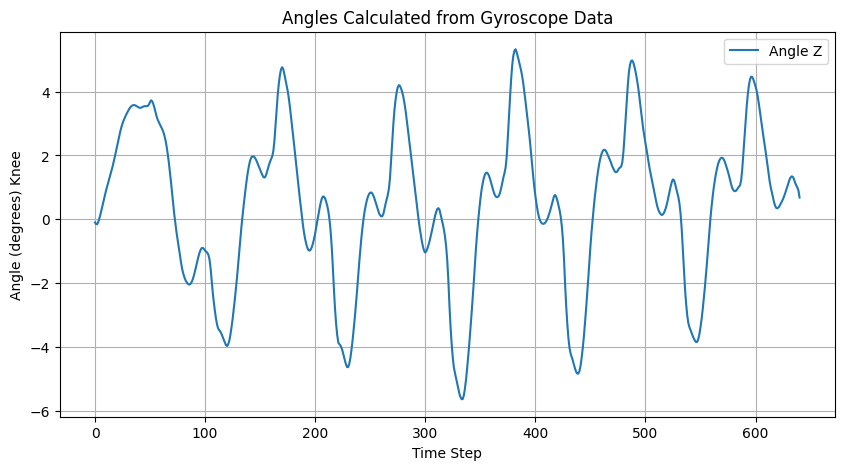

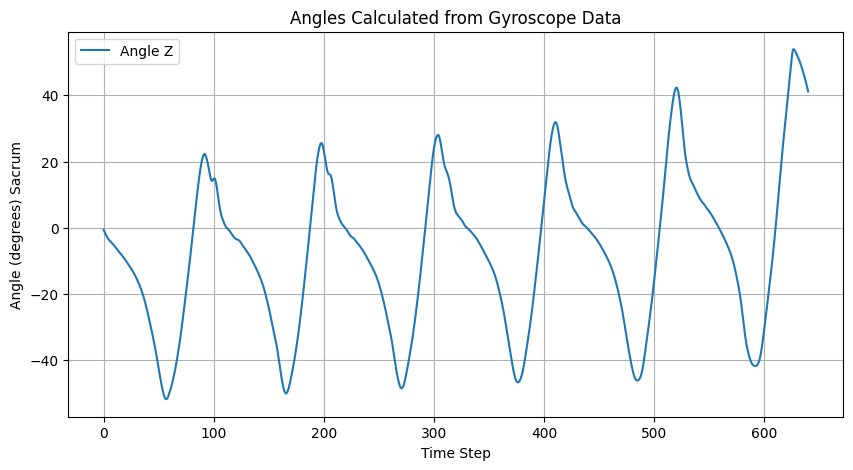

In [86]:
# Example gyroscope data (angular velocity in degrees per second)
# Each row corresponds to [gyro_x, gyro_y, gyro_z] at a time step
gyro_data = signal_Gy

# Time step (in seconds)
dt = gyro_data['seconds_elapsed'][2]-gyro_data['seconds_elapsed'][1]
# Rename column 'Vx3' to 'Vx4'
gyro_data.rename(columns={'Vx3': 'Vx2'}, inplace=True)
features_gyro = ['Vz1', 'Vy1', 'Vx1','Vz2','Vy2','Vx2']
gyro_data=gyro_data[features_gyro]
# Initialize angle variables (in degrees)
angle_x1 = 0.0
angle_y1 = 0.0
angle_z1 = 0.0
angle_x2 = 0.0
angle_y2 = 0.0
angle_z2 = 0.0
# Lists to store angles for plotting
angles_x1 = []
angles_y1 = []
angles_z1 = []
angles_x2 = []
angles_y2 = []
angles_z2 = []
# Integrate angular velocity to get angles
for index, row in gyro_data.iterrows():
  angle_x1 += row['Vx1'] * dt
  angle_y1 += row['Vy1'] * dt
  angle_z1 += row['Vz1'] * dt
  angles_x1.append(angle_x1* 180 / np.pi)
  angles_y1.append(angle_y1* 180 / np.pi)
  angles_z1.append(angle_z1* 180 / np.pi)
  angle_x2 += row['Vx2'] * dt
  angle_y2 += row['Vy2'] * dt
  angle_z2 += row['Vz2'] * dt
  angles_x2.append(angle_x2* 180 / np.pi)
  angles_y2.append(angle_y2* 180 / np.pi)
  angles_z2.append(angle_z2* 180 / np.pi)

# Plotting the angles
plt.figure(figsize=(10, 5))
plt.plot(angles_z1, label='Angle Z')
plt.xlabel('Time Step')
plt.ylabel('Angle (degrees) Knee')
plt.title('Angles Calculated from Gyroscope Data')
plt.legend()
plt.grid(True)
plt.show()
plt.figure(figsize=(10, 5))
plt.plot(angles_z2, label='Angle Z')
#plt.plot(angles_y1, label='Angle Y')
#plt.plot(angles_z1, label='Angle Z')
plt.xlabel('Time Step')
plt.ylabel('Angle (degrees) Sacrum')
plt.title('Angles Calculated from Gyroscope Data')
plt.legend()
plt.grid(True)
plt.show()


**(Filtering)**

## eliminate signals that are below the zero line

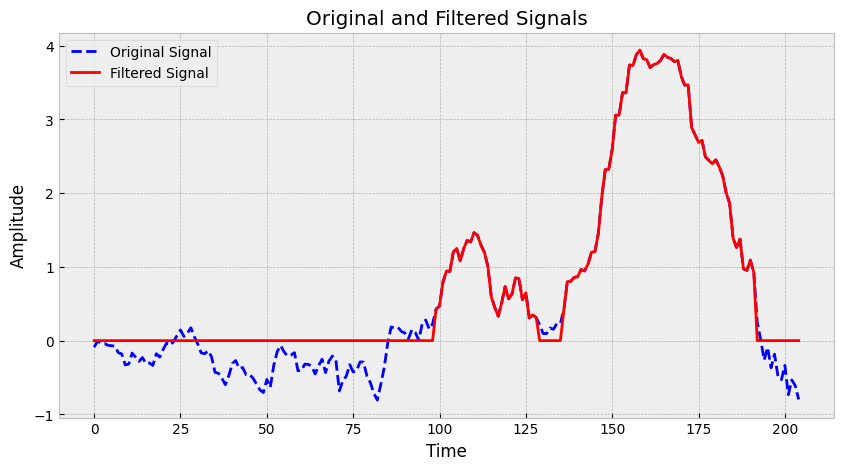

In [49]:
# Eliminate signals below zero and fill with 0
filtered_signal = np.where(signal >= 0.3, signal, 0)
# Convert NumPy array to pandas DataFrame
filtered_signal = pd.DataFrame(filtered_signal, columns=['x', 'y', 'z'])
# نمایش سیگنال اصلی و حذف شده
plt.plot(t, signal[:samples]['z'], label='Original Signal')
plt.plot(t, filtered_signal[:samples]['z'], label='Eliminate Signal', color='red')
plt.xlabel("Time Series")
plt.ylabel("Amplitude")
plt.legend()

plt.figure(figsize=(10, 5))
plt.plot(signal[:samples]['z'], label='Original Signal', color='blue', linestyle='--')
plt.plot(filtered_signal[:samples]['z'], label='Filtered Signal', color='red')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('Original and Filtered Signals')
plt.legend()
plt.grid(True)
plt.show()


## (Moving Average Filter)
مناسب برای هموار کردن سریع سیگنال‌ها با نویز کم

In [ ]:
# فیلتر میانگین متحرک
window_size = 10
moving_average = pd.Series(signal[:samples]['z']).rolling(window=window_size).mean()

# نمایش سیگنال اصلی و هموار شده
plt.plot(t, signal[:samples]['z'], label='Original Signal')
plt.plot(t, moving_average[:samples], label='Moving Average', color='red')
plt.xlabel("Time Series")
plt.ylabel("Amplitude")
plt.legend()

## (Gaussian Filter)
مناسب برای هموار کردن نرم‌تر و با قابلیت تنظیم سیگما

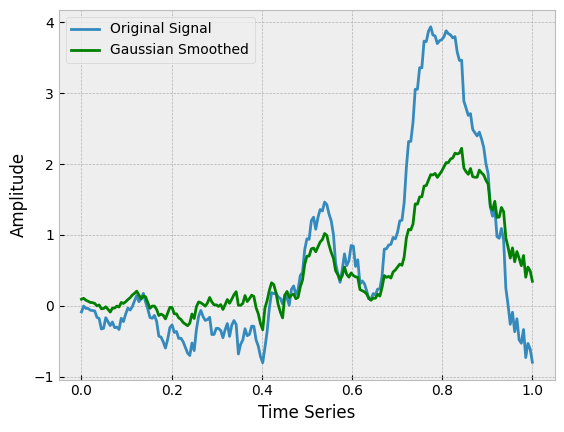

In [13]:
# استفاده از فیلتر گاوسی
sigma = 2  # تنظیم مقدار سیگما
gaussian_smoothed = gaussian_filter1d(signal, sigma=sigma)
# نمایش سیگنال اصلی و هموار شده
#plt.plot(t, signal, label='Original Signal')
#plt.plot(t, gaussian_smoothed, label='Gaussian Smoothed', color='green')
plt.plot(t,signal[:samples]['z'], label='Original Signal')
plt.plot(t,gaussian_smoothed[:samples,2], label='Gaussian Smoothed', color='green')
plt.xlabel("Time Series")
plt.ylabel("Amplitude")
plt.legend()

## (Exponential Moving Average)
وزن بیشتر به داده‌های جدیدتر برای تحلیل‌های سری‌های زمانی

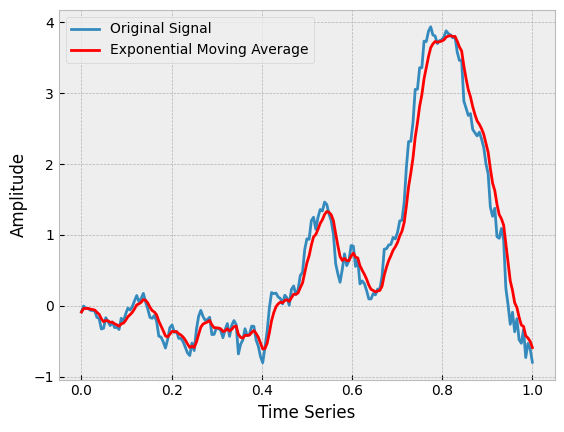

In [14]:
# فیلتر میان‌گین متحرک نمایی
alpha = 0.3
ema = pd.Series(signal[:samples]['z']).ewm(alpha=alpha).mean()

# نمایش سیگنال اصلی و هموار شده
plt.plot(t, signal[:samples]['z'], label='Original Signal')
plt.plot(t, ema[:samples], label='Exponential Moving Average', color='red')
plt.xlabel("Time Series")
plt.ylabel("Amplitude")
plt.legend()

## (Savitzky-Golay)
مناسب برای هموار کردن و حفظ ویژگی‌های سیگنال

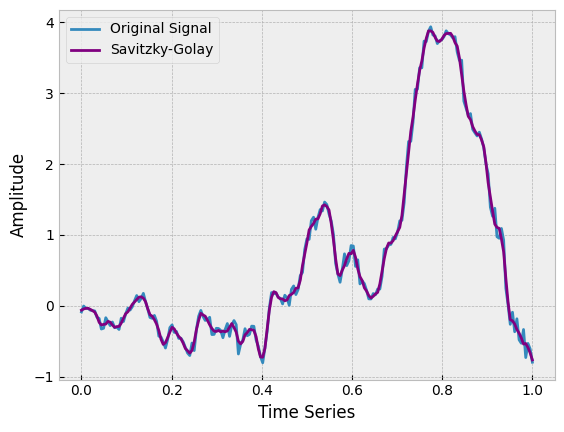

In [15]:
# استفاده از فیلتر Savitzky-Golay
window_length = 7  # باید فرد باشد
polyorder = 2
savgol_smoothed = savgol_filter(signal[:samples]['z'], window_length, polyorder)

# نمایش سیگنال اصلی و هموار شده
plt.plot(t, signal[:samples]['z'], label='Original Signal')
plt.plot(t, savgol_smoothed[:samples], label='Savitzky-Golay', color='purple')
plt.xlabel("Time Series")
plt.ylabel("Amplitude")
plt.legend()

## Feture Extraction

In [ ]:
# نرمال‌سازی داده‌ها
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

peaks_x = extract_peaks(X_scaled[:, 0])
peaks_y = extract_peaks(X_scaled[:, 1])
peaks_z = extract_peaks(X_scaled[:, 2])

features_x = create_feature_data(peaks_x, X_scaled[:, 0])
features_y = create_feature_data(peaks_y, X_scaled[:, 1])
features_z = create_feature_data(peaks_z, X_scaled[:, 2])

# تبدیل داده‌های ویژگی به DataFrame
df_features = pd.DataFrame(features_x + features_y + features_z)

# آماده‌سازی داده‌ها برای مدلسازی
X_features = df_features.values
y_features = np.zeros(X_features.shape[0])  # فرض کنید برچسب‌های اولیه برای آموزش LSTM

In [ ]:
##df_f = pd.DataFrame([{'peak_value': 1,'peak_distance': 2},{'peak_value': 3,'peak_distance': 4}]+[{'peak_value': -1,'peak_distance': -2},{'peak_value': -3,'peak_distance': -4}]+[{'peak_value': 5,'peak_distance': 6},{'peak_value': 7,'peak_distance': 8}])
##X_f = df_f.values
# آماده‌سازی داده‌ها برای مدلسازی
##print(df_f)
##print(df_f.values)
##print(df_f.shape[1] )
##X_f = X_f.reshape((X_f.shape[0], 1, X_f.shape[1]))
##X_f.shape

In [ ]:
# ساخت و آموزش مدل LSTM
# تغییر شکل داده‌ها برای LSTM
X_features = X_features.reshape((X_features.shape[0], 1, X_features.shape[1]))

# ایجاد مدل LSTM
model = Sequential()
model.add(LSTM(64, input_shape=(1, X_features.shape[2]), return_sequences=True))
model.add(LSTM(64))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='linear'))

# کامپایل کردن مدل
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

# آموزش مدل
model.fit(X_features, y_features, epochs=50, batch_size=32, validation_split=0.2)

# ارزیابی مدل
loss, mae = model.evaluate(X_features, y_features)
print(f'Mean Absolute Error: {mae}')

In [ ]:
# پیش‌بینی با داده جدید
peak_value=1.19969738746217
peak_distance=6.666666666666667
new_data = np.array([[peak_value, peak_distance]])
new_data = new_data.reshape((new_data.shape[0], 1, new_data.shape[1]))

prediction = model.predict(new_data)
print(f'Prediction: {prediction}')

# unsupervisor ML

## پیش‌پردازش و استخراج ویژگی‌ها:

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

# فرض کنید که داده‌های سنسورها را در یک فایل CSV جمع‌آوری کرده‌اید
data = dfAccel
# انتخاب ویژگی‌ها
features= ['x', 'y', 'z']
x=data[features]
# نرمال‌سازی داده‌ها
scaler = StandardScaler()
X_scaled = scaler.fit_transform(x)
# اعمال تابع extract_features به هر ستون
#X_features = np.apply_along_axis(extract_features, 1, X_scaled)
X_features = np.apply_along_axis(lambda row: extract_features(row.reshape(1, -1)), 1, X_scaled)
 # اطمینان از مطابقت طول‌ها
print(X_features.shape)
print(x.shape)
#print(len(X_features))
#print(len(data))

## اجرای مدل K-Means:

In [ ]:
# استفاده از الگوریتم K-Means
kmeans = KMeans(n_clusters=3, random_state=42)  # تعداد کلاسترها را مشخص کنید
kmeans.fit(X_features)

# افزودن نتایج کلاسترینگ به داده‌ها
data['cluster'] = kmeans.labels_

# نمایش نتایج
plt.scatter(data['x'], data['y'], c=data['cluster'])
plt.xlabel('Accelerometer X')
plt.ylabel('Accelerometer Y')
plt.title('K-Means Clustering')
plt.show()

# بررسی ویژگی‌های هر کلاستر
print(data.groupby('cluster').mean())



## اجرای مدل DBSCAN:

In [ ]:

# استفاده از الگوریتم DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=5)
clusters = dbscan.fit_predict(X_features)

# افزودن نتایج کلاسترینگ به داده‌ها
data['cluster'] = clusters

# نمایش نتایج
plt.scatter(data['x'], data['y'], c=data['cluster'])
plt.xlabel('Accelerometer X')
plt.ylabel('Accelerometer Y')
plt.title('K-Means Clustering')
plt.show()

# بررسی ویژگی‌های هر کلاستر
print(data.groupby('cluster').mean())


## اجرای مدل Hierarchical Clustering:

In [ ]:
# استفاده از الگوریتم Hierarchical Clustering
linked = linkage(X_features, method='ward')
dendrogram(linked, orientation='top', distance_sort='descending', show_leaf_counts=True)
plt.show()

# اجرای مدل Agglomerative Clustering
hc = AgglomerativeClustering(n_clusters=3, metric='euclidean', linkage='ward')
clusters = hc.fit_predict(X_features)

# افزودن نتایج کلاسترینگ به داده‌ها
data['cluster'] = clusters

# نمایش نتایج
plt.scatter(data['x'], data['y'], c=data['cluster'])
plt.xlabel('Accelerometer X')
plt.ylabel('Accelerometer Y')
plt.title('K-Means Clustering')
plt.show()

# بررسی ویژگی‌های هر کلاستر
print(data.groupby('cluster').mean())


## کد تحلیل الگوها

In [ ]:
# تحلیل الگوهای هر کلاستر
clusters = data['cluster'].unique()

for cluster in clusters:
    cluster_data = data[data['cluster'] == cluster]
    print(f"Cluster {cluster}:")
    print(cluster_data.describe())


## کد برای کلاسترینگ و ایجاد برچسب‌های اولیه

In [ ]:
# استفاده از الگوریتم K-Means برای کلاسترینگ
kmeans = KMeans(n_clusters=5, random_state=42)
kmeans.fit(X_scaled)
data['pseudo_labels'] = kmeans.labels_

# استفاده از برچسب‌های اولیه برای آموزش مدل نظارتی
X_train, X_test, y_train, y_test = train_test_split(X_scaled, data['pseudo_labels'], test_size=0.2, random_state=42)

# آموزش مدل Random Forest
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# ارزیابی مدل
predictions = model.predict(X_test)
mse = mean_squared_error(y_test, predictions)
print(f"Mean Squared Error: {mse}")

### Prediction

In [ ]:
# پیش‌بینی با داده جدید
#new_data = np.array([[accel_x, accel_y, accel_z, gyro_x, gyro_y, gyro_z, magnet_x, magnet_y, magnet_z]])
accel_x, accel_y, accel_z = eval(input("سه مقدار شتاب بترتیب در راستای محورهای طول و عرض و ارتفاع وارد کنید: "))
new_data = np.array([[accel_x, accel_y, accel_z]])
new_data_scaled = scaler.transform(new_data)
new_prediction = model.predict(new_data_scaled)
print(f"Prediction: {new_prediction}")

## LSTM برای تحلیل داده‌های سری زمانی

In [ ]:
seq_length = 10  # طول توالی‌ها
X_sequences = create_sequences(X_scaled, seq_length)

# استفاده از الگوریتم K-Means برای کلاسترینگ و ایجاد برچسب‌های اولیه
kmeans = KMeans(n_clusters=5, random_state=42)
pseudo_labels = kmeans.fit_predict(X_scaled)

# همگام‌سازی برچسب‌ها با توالی‌ها
y_sequences = pseudo_labels[seq_length:]

# ایجاد مدل LSTM
model = Sequential()
model.add(LSTM(64, input_shape=(seq_length, X_sequences.shape[2]), return_sequences=True))
model.add(LSTM(64))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='linear'))  # خروجی مدل براساس تعداد کلاسترها یا برچسب‌های اولیه

# کامپایل کردن مدل
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

# آموزش مدل
model.fit(X_sequences, y_sequences, epochs=50, batch_size=32, validation_split=0.2)

# ارزیابی مدل
loss, mae = model.evaluate(X_sequences, y_sequences)
print(f'Mean Absolute Error: {mae}')

# پیش‌بینی با داده جدید
new_data = np.array([X_scaled[-seq_length:]])
prediction = model.predict(new_data)
print(f'Prediction: {prediction}')


# Find Prime

In [ ]:
# ورودی عدد صحیح
number = int(input("یک عدد صحیح وارد کنید: "))
print_primes(number)

In [ ]:
# Example usage:
characters = ['a', 'a', 'b', 'b', 'b', 'c', 'a', 'a', 'd', 'd', 'd', 'd']
count_sequences(characters)

In [ ]:
# مقادیر واقعی و پیش‌بینی
y_true = [0, 0, 1, 1]
y_scores = [0.2, 0.5, 0.35, 0.8]

# محاسبه حساسیت و 1-اختصاصی‌بودن
fpr, tpr, thresholds = roc_curve(y_true, y_scores)

# محاسبه AUC
roc_auc = auc(fpr, tpr)

# رسم نمودار ROC
plt.figure()
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='grey', linestyle='--')
plt.xlabel('1 - Specificity (FPR)')
plt.ylabel('Sensitivity (TPR)')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()
